# Import

In [3]:
path_qudi = r'C:\Users\Timo\OneDrive\_Promotion\Software\qudi'
path_notebooks = r"C:\Users\Timo\OneDrive\_Promotion\Software\qudi\user_scripts\Timo\own"
path_plotlib = path_notebooks + r'/mfl_analysis_lib.py'

import pandas as pd
import os.path
from core.util.math import compute_ft

import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import copy as cp
from enum import Enum
from scipy.linalg import sqrtm
import scipy.interpolate

from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

try:
    os.chdir(path_notebooks)
    exec(open(path_plotlib).read())
except:
    logger.exception("")
    
os.getcwd()


'C:\\Users\\Timo\\OneDrive\\_Promotion\\Software\\qudi\\user_scripts\\Timo\\own'

In [501]:
from matplotlib.colors import LinearSegmentedColormap


common_params = {'data_path': r"E:\Timo\Data", #r"E:\Data_Paper_DNV",
                 'copy_2_path':  r'', 
                 
                 'tau1_2q': 800e-9,
                 'tau2_zz': 271.1e-9,   # deer calib @ Rabi= 22.98 MHz (settings close to EPC mes), 20231202-1131-45
                 'xy8_order_2q': 1,
                 't_rabi_opt': 42e-9,
                 't2_xy8': [476e-6, 454e-6],
                 # GPC: labbook 12.9.23
                 'rb_gpc': {'cx': 1.8, '1q': 10.53},   # total 1qs, not per qubit
                 'rb_2q_nocnot_gpc': {'1q': 11.51},
                 'rb_1q_gpc': {'1q': 1.969}
}




# Paper
default_params = {'legend.fontsize': 6,
          'figure.figsize': (3.5, 3.5*2./3.),   # standard 1 colum Nature fig
         'axes.labelsize': 8,
         'axes.titlesize':'xx-large',
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'lines.markeredgewidth':0,
         #'lines.linewidth': 2,
         'errorbar.capsize': 2.5,
         'xtick.minor.visible': True,
         'figure.dpi': 300,
         'savefig.dpi': 300}

# Slides
"""
default_params = {'legend.fontsize': 6,
          'figure.figsize': (4, 4*2./3.),   # standard 1 colum Nature fig
         'axes.labelsize': 10,
         'axes.titlesize':'xx-large',
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'lines.markeredgewidth':0,
         #'lines.linewidth': 2,
         'errorbar.capsize': 5}
"""
plt.rcParams.update(default_params)

class CommonPlt(object):
    def __init__(self):
        self.perform_save = True
        self.save_csv = True
        
        self.save_extension = 'svg'
        self._savepath =  r"C:\Users\Timo\Desktop\_thesis_figs\mfl\\"
        self._cmap_n_bins= [5,100]
    
    def _save_fig_data(self, fig, name):
        axs = fig.get_axes()

        data = []
        for ax in axs:
            lines = ax.get_lines()
            scatters = ax.collections
            d = [{'x': l.get_xdata(), 'y': l.get_ydata(), 'label': l.get_label()} for l in lines]
            data.extend(d)
            
            # scatter plots
            d = [{'x': s.get_offsets()[:,0], 'y':s.get_offsets()[:,1], 'label': s.get_label()} for s in scatters]
            data.extend(d)
            
        fname = plt_settings.get_savepath(name, extension='csv')
        df = pd.DataFrame(data)
        df.to_csv(fname)
        logger.debug(f"Saved fig data to: {fname}")

    
    def savefig(self, name, save_csv=None, frame_left_inch=2*0.35, frame_bottom_inch=2.5*0.22, 
                frame_top_inch=None, frame_right_inch=None):
        
        if save_csv is None:
            save_csv = self.save_csv
        
        fig = plt.gcf()
        fig_size = fig.get_size_inches()
        
        # make the frame size fixed in inches
        # specify relative to figsize in function
        
        left_rel = frame_left_inch/fig_size[0]
        if frame_right_inch is None:
            right_rel = 1.2*(1 - left_rel)
        else:
            right_rel = 1 - (frame_right_inch/fig_size[0])

        bottom_rel = frame_bottom_inch/fig_size[1]
        if frame_top_inch is None:
            top_rel = 1.1*(1 - bottom_rel)
        else:
            top_rel = 1 - (frame_top_inch/fig_size[1])

        plt.subplots_adjust(left=left_rel, right=right_rel,
                            top=top_rel, bottom=bottom_rel)

        # overwrite tight_layout parameters and save with a fixed frame
        if save_csv:
            self._save_fig_data(fig, name)
        plt.savefig(plt_settings.get_savepath(name))
    
    def get_figsize(self, n_cols=2):
        figsize = default_params['figure.figsize']
        fig_width = 2*figsize[0]/n_cols
        fig_height = fig_width* 2/3
        
        return [fig_width, fig_height]
    
    def get_markersize(self, size='medium', is_scatter=False, rel_to_fig=True):
        # https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
        size_dict = {'small':2, 's-medium':4, 'medium': 5, 'big': 7}
        
        scale_fac = 1
        if rel_to_fig:
            fig = plt.gcf()
            fig_size = fig.get_size_inches()
            fig_size_default = plt.rcParams['figure.figsize']
            
            idx = np.argmax(np.abs(fig_size/fig_size_default - 1))
            scale_fac = (fig_size/fig_size_default)[idx]
        
        if is_scatter:
            return (scale_fac*size_dict[size])**2
        
        return scale_fac*size_dict[size]
        
    def get_savepath(self, fname, extension=None):
        
        fname = fname.replace(".png","").replace(".svg","svg")
        if extension is None:
            extension = self.save_extension
        
        if not self.perform_save:
            return ""
        return self._savepath + fname + "." + extension
    
    def get_cmap(self, continuous=True):
        cmaps = self._create_cmap()
        cmap = None
        
        for key, val in cmaps.items():
            if continuous:
                if not 'cont' in key:
                    continue
            else:
                 if 'cont' in key:
                    continue
            cmap = val
        
        return cmap
    
    def color(self, colorstr=None, alpha=1):
        color_map = {'blue':0, 'bluelight':1, 'red':4, 'green':2, 'orange':3}
        if colorstr is not None:
            if colorstr == 'grey':
                # handle grey outside of color cycle, #a9a28dff
                return tuple([0.6627, 0.63529, 0.5529, alpha])
            if colorstr not in color_map.keys():
                raise ValueError
            else:
                color = self.get_cmap(False)(color_map[colorstr])

                color_alpha = list(color)[0:3]
                color_alpha.append(alpha)
                
                return tuple(color_alpha)
            
    def marker_style(self, color, is_scatter=False, is_err=False, size='medium'):
        marker_style = dict(marker='o',
                            color=color,
              )
        
        err_style = dict(capthick=1, elinewidth=1, capsize=1.5)
        
        
        if is_scatter:
              marker_style = {**dict(s=plt_settings.get_markersize(is_scatter=True, size=size),
                                    facecolor=color,
                                    linewidths=1,
                                    edgecolor='grey'), **marker_style}
            
        elif not is_scatter and not is_err:
             marker_style = {**dict(markersize=plt_settings.get_markersize(is_scatter=False, size=size),
                                    markerfacecolor=color,
                                    markeredgewidth=1,
                                    markeredgecolor='grey',
                                    linestyle=''), **marker_style}
        
        elif is_err:
             marker_style.update(err_style)
        else:
            raise ValueError
        
        return marker_style
    
    def _create_cmap(self):
        colors_uulm = ['#26547c', '#7d9aaa', '#56aa1c', '#df6d07', '#a32638']#, '#a9a28d'] 
        n_bins = self._cmap_n_bins  # Discretizes the interpolation into bins

        cmap_name = ['uulm_5', 'uulm_cont']
        idx = 0
        
        cmaps = {}
        for n_bin in n_bins:
            # Create the colormap
            cmap = LinearSegmentedColormap.from_list(cmap_name[idx], colors_uulm, N=n_bin)
            cmaps[cmap_name[idx]] = cmap
            idx += 1
            
        return cmaps        
    

    
plt_settings = CommonPlt()
try:
    plt_settings.get_cmap(False)
    #plt_settings.get_cmap(False)

    #plt_settings._create_cmap()['uulm_cont']
    plt_settings.color('red')


    a = plt_settings.get_markersize(size='medium', is_scatter=False)
    a = plt_settings.marker_style('blue', is_err=True)
except:
    logger.exception("")
    
plt_settings.get_cmap(False)(100)
plt.rcParams['figure.figsize']

[3.5, 2.3333333333333335]

In [496]:
plt_settings.get_savepath('odmr.png', extension='csv')

'C:\\Users\\Timo\\Desktop\\_thesis_figs\\\\odmr.csv'

In [39]:
n_bins = [5, 100]

x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y) * 10

cmap_name = ['uulm_5', 'uulm_cont']
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)

idx = 0
for n_bin, ax in zip(n_bins, axs.flat):
    # Create the colormap
    cmap = plt_settings.get_cmap(idx%2)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, origin='lower', cmap=cmap)
    ax.set_title("N bins: %s" % plt_settings._cmap_n_bins[idx])
    fig.colorbar(im, ax=ax)
    idx += 1

plt.tight_layout()
plt.show()

# Library

In [80]:
import lmfit
from scipy.interpolate import UnivariateSpline
import shutil
from pathlib import Path   
import pandas as pd
import difflib

def copy_to_path(fname, do_copy=None, target_path=None):
    if target_path is None:
        target_path = common_params['copy_2_path']  
    
    if do_copy is None:
        do_copy = False
        if target_path:
            do_copy = True
    
    path = Path(fname)
    if path.is_file():
        folder_file = os.path.dirname(fname)
    elif path.is_dir():
        folder_file = os.path.abspath(fname)
    else:
        raise ValeuError(f"Must give path to file or directory, not: {fname}")
        
    orig_path = common_params['data_path']
    folder_target = folder_file.replace(orig_path, target_path)
    
    logger.debug(f"Creating copy of data: {folder_file} -> {folder_target}")
    
    if do_copy:
        if os.path.exists(folder_target):
            shutil.rmtree(folder_target)
        shutil.copytree(folder_file, folder_target)

    return do_copy

"""
def copy_to_path(fname, do_copy=None, target_path=None):
    if target_path is None:
        target_path = common_params['copy_2_path']  
    
    if do_copy is None:
        do_copy = False
        if target_path:
            do_copy = True
        
    folder_file = os.path.dirname(fname)
    orig_path = common_params['data_path']
    folder_target = folder_file.replace(orig_path, target_path)
    
    logger.debug(f"Creating copy of data: {folder_file} -> {folder_target}")
    
    if do_copy:
        if os.path.exists(folder_target):
            shutil.rmtree(folder_target)
        shutil.copytree(folder_file, folder_target)

    return do_copy
"""


def _norm_sim_2_exp(y, rb_y0=None, orig_range=[0,1], new_range=[0,1]):
    #return y
    y = cp.copy(y)
    
    if rb_y0 is None:
        rb_y0 = 0.7   # eg. explainable by charge state

    interp_func = scipy.interpolate.interp1d(orig_range, new_range,
                                             kind='linear', fill_value='extrapolate')
    
    y = interp_func(y)
    # can't norm every sim to max of exp
    #y = y - 0.42
    #y = y/np.max(y) # norm to 1
    #y = y*y_max_60g # align with max of exp data
    #return y
    return rb_y0*y #- 0.2 #0.9*y - 0.3



def coherence_epc_limit_simple(t_gate_1q, t_gate_2q, gpc, t2):
    # qiskit coherence_limit uses a not well documented estimation
    # that might be related to arxiv:2007.02925, arxiv: 2302.10881
    
    # here, we just calculate the single T2 exponential decay over the gate_length
    # open question, which T2 to use for 1q gates. But contribution is very small at high Rabi anyway



    p_1q = np.exp(-t_gate_1q/t2)
    p_2q = np.exp(-t_gate_2q/t2)

    p_tot = p_1q**gpc['1q'] * p_2q**gpc['cx']

    epc_tot = 1-p_tot

    return epc_tot

def coherence_epg_limit_simple(t_gate, t2):
    return coherence_epc_limit_simple(t_gate, 0, {'cx':0, '1q':1}, t2)


def plot_multiple_1d(p_raw, n_datas=1, plot_err=False, plot_mode='delta',
                     scale_fac_x=1, scale_fac_y=1, color=None, offset=0, marker_size='medium',
                    smooth_data=False, marker_style=None, alpha=None, alpha_line=0.9):
    #"""
    plot_data = []
    #plt.figure(figsize=(6,4))
    
    
    try:
        for i, mes in enumerate(p_raw):

            x_i = scale_fac_x*np.asarray(mes['data']['tau'])
            y_i = offset*i +  scale_fac_y*np.asarray(get_z(mes, mode=plot_mode)[0])
            if plot_err:
                dy_i =   scale_fac_y*np.asarray(get_z(mes, mode=plot_mode)[1])
            
            #logger.info(f"{y_i}")
            
            poi_id = mes['file']#.split('nv_')[2].split("\\")[0]
            poi_id = int(not(i))

            # colormap
            #color=None
            #color = plt.cm.plasma(i/len(p_raw))
            if color is None:
                color_i = plt_settings.get_cmap(False)(int((i)/(len(p_raw)*n_datas)))
            else:
                color_i = color
            
            #if alpha is None:
            #    alpha = 0.8
            if marker_style is None:
                marker_style_i = plt_settings.marker_style(color_i, is_scatter=True, size=marker_size)
            else:
                 marker_style_i = marker_style[i]
            marker_err_style = plt_settings.marker_style(color_i, is_scatter=False, is_err=True, size=marker_size)   

            label = None
            plot_options = mes.get('plot_options')
            if plot_options:
                label = plot_options.get('label')
            if label is None:
                label= f"{mes['exp_params']['savetag']}"
            #label = f"control= |{poi_id}>"
            #label = f"read_phase= {mes['exp_params']['read_phase']:.1f}"

            plt.scatter(x_i, y_i, label=label, alpha=alpha, zorder=10, **marker_style_i)
            if plot_err:
                plt.errorbar(x_i, y_i, yerr=dy_i, 
                          alpha=0.7, label='_no_legend', 
                          **marker_err_style,
                          markersize=0, linestyle='', zorder=1)

            """
            if dy_i is not None:
                plt.errorbar(x_i, y_i, yerr=dy_i, label='_nolegend_', color=color, marker="", alpha= 0.15)
            else:
                pass
                #plt.plot(x_i, y_i, label='_nolegend_', color=color, marker="", alpha= 0.15)
            """
            if smooth_data:
                zipped = sorted(zip(x_i, y_i), key=lambda x: x[0])  # raw data x sometimes reversed
                x_in, y_in = [s[0] for s in zipped],[s[1] for s in zipped]
                spline = UnivariateSpline(x_in, y_in)
                x_smooth_i = np.linspace(np.min(x_i), np.max(x_i), 500)
                y_smooth_i = spline(x_smooth_i)
                plt.plot(x_smooth_i, y_smooth_i, label='_nolegend_', color=color_i, marker="", alpha= 0.9)

            if 'fit_values' in mes.keys():
                x_fit = scale_fac_x*mes['fit_values']['x']
                y_fit = offset*i+ scale_fac_y*mes['fit_values']['y']
                plt.plot(x_fit, y_fit, label='_nolegend_', color=color_i, marker="",
                         alpha=alpha_line, linewidth=2)

            #plt.xlim([0, 17])
            #plt.ylim([-0.2,0.1])

            plot_data.append([x_i,y_i])

        
        #plt.xlabel("clifford length ()")
        plt.xlabel(r"$t_{evol}$ " + f"({x_unit})")
        plt.ylabel(r'$\sigma_y$')
     
    except:
        logger.exception(f"In mes {p_raw[i]['file']}")
    
    return plot_data


def norm_on_delta(p_data, idx_zref=None, mask_idxs=[]):
    if idx_zref != None:

        p_data = pd.DataFrame(p_data)
        delta = p_data['z1']-p_data['z2']
        ddelta = np.sqrt(p_data['dz1']**2+p_data['dz2']**2)
        z_ref = delta.iloc[idx_zref] 

        y_scale = 1/z_ref

        if len(mask_idxs) != 0:
            mask_idxs = [i if i>=0 else len(p_data)+i for i in mask_idxs]  # handle negative idx
            try:
                p_data = p_data.drop(mask_idxs)
                delta = delta.drop(mask_idxs)
                ddelta = ddelta.drop(mask_idxs)
                logger.debug(f"Dropped norm datapoint z={z_ref}")
            except KeyError: # already dropped before, don't norm again
                p_data['delta'] = delta
                p_data['ddelta'] = ddelta
                logger.warning("Skipping norming, already dopped reference data before.")
                return p_data
                
                
            
        p_data['delta'] = y_scale*delta
        p_data['ddelta'] = y_scale*ddelta
        
    return p_data

def setup_clear_plots(n_plots):
    n_cur = qdplotlogic.number_of_plots
    for i in range(n_cur):
        n_cur_i = qdplotlogic.number_of_plots
        if n_cur_i >= 1:
            # removing without arguments seems buggy
            qdplotlogic.remove_plot(n_cur_i-1)
    
    for i in range(n_plots):
        qdplotlogic.add_plot()
def extract_num_from_path(file):
    fname = os.path.basename(file)
    res = Tk_string.find_num_in_str(fname)
    
    return res

"""
# delete if Tk_file import works
def load_pulsed_result(fname):

    data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "z2", "std1", "std2"])
    if pd.isnull(data.iloc[0, -1]):
        data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "std1"])
    meta = Tk_file.load_pulsed_metadata(fname)

    mes = {'data': data,
           'file': fname}
    mes = {**mes, **meta}

    return mes
"""
def do_fit(p_mes, fit_y='delta', fit_method='sine', edit_params=None, settings=None):
    fitter = pulsedmeasurementlogic.fc   
    
    if edit_params:
        for ov_param in edit_params:
            
            if ov_param.name in fitter.fit_list[fit_method]['parameters'].keys():
                fitter.fit_list[fit_method]['use_settings'][ov_param.name] = True
                fitter.fit_list[fit_method]['parameters'][ov_param.name] = ov_param
                
                #logger.debug(f"Overwriting fit param {ov_param.name}: {ov_param}")

    fitter.clear_result()
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """

    if fit_y == 'delta':
        data = np.asarray(p_mes['data']['tau']), np.asarray(delta_or_z1(p_mes))
    elif fit_y == 'z1':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z1'])
    elif fit_y == 'z2':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z2'])
    else:
        raise ValueError
    
    #logger.info(f"data({fit_y})= {data}")
    
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    # params [lmfit::Parameters] and derived params [dict]
    # considered in _get_fit()
    
    # get values of fitted model
    model = fitter.fit_list[fit_method]['make_model']()[0]
    
    x_domain = np.asarray(p_mes['data']['tau'])
    x_domain = np.linspace(np.min(x_domain), np.max(x_domain), 1000)
    if settings:
        if 'fit_range' in settings.keys():
            x_domain = settings['fit_range']

    y = model.eval(x=x_domain, params=result.params)
    fit_vals = {'x': x_domain, 
                'y': y}
    
    full_result = {**result.params, **result.result_str_dict}
    p_mes['fit_res'] = full_result
    p_mes['fit_values'] = fit_vals
    
    reset_fitter(fit_method, edit_params)

def reset_fitter(fit_method=None, edit_params=None):
    fitter = pulsedmeasurementlogic.fc   
    
    if edit_params:
        for ov_param in edit_params: 
            if ov_param.name in fitter.fit_list[fit_method]['parameters'].keys():
                fitter.fit_list[fit_method]['use_settings'][ov_param.name] = False   
    
    
def get_z(p_mes, mode='z1'):
    # mode: z1, z2, delta, (+_norm)
    try:
        has_z2 = True
        has_delta = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False
        try:
            delta = p_mes['data']['delta']
            ddelta = p_mes['data']['ddelta']
        except KeyError:
            has_delta = False
            
        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)
        dz1 = p_mes['data'].get('std1')

        if mode == 'z1':
            return z1, dz1
        elif mode == 'z1_norm':
            return z1_norm, dz1/z1*z1_norm
        elif mode == 'z2' or mode == 'z2_norm' or mode=='delta' or mode=='delta_norm':
            if has_z2:
                z2 = p_mes['data']['z2']
                dz2 = p_mes['data'].get('std2')
        
                delta = (z1-z2) if not has_delta else delta
                ddelta = np.sqrt(dz1**2+dz2**2) if not has_delta else ddelta
                delta_norm = delta/np.average(z1)
            else:
                raise KeyError
                
            if mode == 'z2':
                return z2, dz2
            if mode == 'z2_norm':
                return z2/np.average(z2), dz2/z2*z2_norm
            if mode == 'delta':
                return delta, ddelta
            if mode == 'delta_norm':
                return delta_norm, np.sqrt(dz1**2+dz2**2)/delta * delta_norm
        else:
            raise ValueError(f"Unknown mode: {mode}")  

    except:
        logger.exception(f"Loading of {mode} from file {p_mes['file']} failed")
        raise  

def delta_or_z1(p_mes, norm=False):
    try:
        
        ret = None
        
        has_delta = True
        try:
            delta = p_mes['data']['delta']
            ret = delta
        except KeyError:
            has_delta = False
        
        has_z2 = True
        try:
            z2 = p_mes['data']['z2']
        except KeyError:
            has_z2 = False
        
        try:
            z1 = p_mes['data']['z1']
        except KeyError:
            pass

        if has_z2 and not has_delta:
            delta = (z1-z2)
            ret = delta

        if norm:
            return ret/np.average(ret)
        return ret
    except:
        logger.exception(f"Loading of file {p_mes['file']} failed: {p_mes['data']}")
        raise
        


def pulsed_series_2_array(p_raw, idx_var_y=None, ordered_y=True):
    y2d = []
    z1s, z2s = [], []
    x2d = []

    for p in p_raw:
        try:
            z1 = p['data']['z1']
            try:
                z2 = p['data']['z2']
            except:
                z2 = np.nan
            # set x axis of 2d plot
            tau = p['data']['tau']
            # set y axis of 2d plot
            idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_y != None:
                var_file = float(extract_num_from_path(p['file'])[idx_var_y])
            # set y axis as time of mes
            if idx_var_y == None:
                var_file = p['date'].timestamp() - p_raw[0]['date'].timestamp()
            #logger.info(f"1st: tau {tau}, x2d {x2d}")
            if len(x2d) > 0:
                err = f"Data in file {p['file']} doesn't share tau axis"
                try:
                    if not np.all(x2d == tau):
                        raise ValueError(err)
                except:
                    logger.exception(err)
                    raise


            x2d = tau
            #logger.info(f"tau {tau}, x2d {x2d}")
            y2d.append(var_file)
            z1s.append(z1)
            z2s.append(z2)

        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise



    z1s = np.asarray(z1s)
    z2s = np.asarray(z2s)

    x2d = np.asarray(x2d)
    y2d = np.asarray(y2d)
    
    if ordered_y:
        y2d,  z1s, z2s = np.sort(y2d), z1s[y2d.argsort()], z2s[y2d.argsort()]
    
    return x2d, y2d, z1s, z2s


def pulsed_series_2_1d_fit_array(pulsed_series, fit_meth, fit_on, fit_vals,
                                 idx_var_x=None, ordered_x=True):
    
    x,y, y2, y3 = [], [], [], []
    dy = []
    
    for p in pulsed_series:
        try:
            # set x axis of 1d plot
            # idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_x:
                var_file = float(extract_num_from_path(p['file'])[idx_var_x])
            # set y axis as time of mes
            else:
                var_file = p['date'].timestamp() - pulsed_series[0]['date'].timestamp()
            x.append(var_file)
            
            # looks for fit params to overwirte
            edit_params, settings = None, None
            if 'fit_edit_params' in p.keys():
                edit_params = p['fit_edit_params']
            if 'fit_settings' in p.keys():
                settings = p['fit_settings']
            
            #logger.debug(f"{x}")
            # fit result on y axis
            #break
            do_fit(p, fit_y=fit_on, fit_method=fit_meth,
                   edit_params=edit_params, settings=settings)
            
            logger.debug("Fit done")
            y.append(_get_fit(p, 0, error=False, cust_vals=fit_vals))
            dy.append(_get_fit(p, 0, error=True, cust_vals=fit_vals))
            y2.append(_get_fit(p, 1, error=False, cust_vals=fit_vals))
            y3.append(_get_fit(p, 2, error=False, cust_vals=fit_vals))


        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise

    x, y, y2, y3, dy = np.asarray(x), np.asarray(y), np.asarray(y2),  np.asarray(y3), np.asarray(dy)
    if ordered_x:
        x, y, y2, y3, dy = np.sort(x), y[x.argsort()], y2[x.argsort()], y3[x.argsort()], dy[x.argsort()]
    
    return x, y, y2, y3, dy

def _get_fit(p, y_idx=0, error=False, cust_vals=None):
    
    fit_vals = ['Lifetime', 'Contrast', 'Frequency']
    if cust_vals:
        fit_vals = cust_vals
    try:
        param = p['fit_res'][fit_vals[y_idx]]
        if isinstance(param, lmfit.parameter.Parameter):
            fit_quant = 'stderr' if error else 'value'
            return getattr(param, fit_quant)
        elif isinstance(param, dict):
            fit_quant = 'error' if error else 'value'
            return param[fit_quant]
        else:
            raise ValueError(f"Didn't understand fit param type: {type(params)}")
    except:
        return -1




def overwrite_poi_from_foldername(p_mes):
    # needed, if "Active POI:" property in .dat file is buggy
    path = os.path.normpath(p_mes['file'])
    poi = path.split(os.sep)[-2][:]
    try:
        poi = 'nv_' + poi.rsplit('nv_',1)[1]
    except IndexError:
        return
    #return poi
    #poi.rsplit(poi, '')
    
    if 'Pulsed' in poi:
        return
    else:
        p_mes['poi'] = poi
        return poi

def find_param_file(p_mes):
    return Tk_file.find_param_file(p_mes)

def extract_params_from_file(header_lines):

    header_flat = ' '.join([line for line in header_lines])
    text = header_flat

    # time of experiment
    m = re.search('on(.+?)\n', text)
    if m:
        found = m.group(1)
    date = pd.to_datetime(found, dayfirst=True)

    # poi
    m = re.search('POI:(.+?)\n', text)
    if m:
        found = m.group(1)
    poi = found.lstrip()

    meta = {'date': date,
            'poi': poi}
    return meta

    
def load_param_file(fname):
        
    return Tk_file.load_param_file(fname)

def load_pulsed_params(p_mes):
    fname = find_param_file(p_mes)
    return load_param_file(fname)
    
def decay_fit(p_in, name_timeconst='T2_he', fit_meth='exp_decay'):
    y_val_idx = None
    fit_on = 'delta'
    fit_vals = ['Lifetime', 'None', 'None']
    
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)
    for p in p_in:
        p[f"fit_res_{name_timeconst}"] = p['fit_res']

def nv_class_for_exp(p_in, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    for p in p_in:
        try:
            f_mw = load_pulsed_params(p)['microwave_frequency']
            p['exp_on_fres'] = NVClass(find_closest(f_mw, f_res_classes=f_res_classes))
        except KeyError:
            pass
            

def find_best_lor_fit(p_in, fit_meths=['lor_dip', 'lor_dip_2x']):
    
    for i, fmeth in enumerate(fit_meths):
        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fmeth
        fit_vals = ['Position 0', 'Position 1', 'Position 2']    
        if i == 0:
            fit_vals[0] = 'Position'
        
        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                        idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fmeth}"] = p['fit_res']

        """
        # fit_res is updated after

        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fit_meths[1]
        fit_vals = ['Position 0', 'Position 1', 'None']    

        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                    fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fit_meths[1]}"] = p['fit_res']
        """

from enum import IntEnum        
class NVClass(IntEnum):
    NOT_CLASSIFIED = -1
    NO_ODMR = -2
    A = 0
    B = 1
    C = 2
    D = 3

    
def classify_nv_orientation(p_mes, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):
    """
    fit meths should be ordered in the number of nvs they correscpond.
    -> lor_dip, lor_dip_2x => n=[1,2]
    """
    p = p_mes
    nv_class = None
    
    chis = []
    for fit in fit_meths:
        if f"fit_res_{fit}" in p.keys():
            chis.append(p[f"fit_res_{fit}"]['chi_sqr']['value'])
    
    i_chi = np.argmin(np.asarray(chis)) 
    n_nv = i_chi + 1
    nv_classes = []
    
    for i_line in range(0, n_nv):
        if n_nv <= 1:
            f_res_i = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        else:    
            f_res_i = p[f"fit_res_{fit_meths[i_chi]}"][f'Position {i_line}']['value']

        nv_class_i = find_closest(f_res_i, f_res_classes=f_res_classes)
        nv_classes.append(NVClass(nv_class_i))
    
    for i_line in range(0, n_nv):
        if not classify_has_odmr(p, nv_classes, fit_meths=fit_meths, snr_thresh=snr_thresh)[i_line]:
            nv_classes[i_line] = NVClass.NO_ODMR

    """
    # smaller chisqr: better fit
    if chisqr_0 < chisqr_1:
        f_res = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        nv_class = [NVClass(find_closest(f_res, f_res_classes=f_res_classes))]
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class = [NVClass.NO_ODMR]

    else:
        f_res_0 = p[f"fit_res_{fit_meths[1]}"]['Position 0']['value']
        f_res_1 = p[f"fit_res_{fit_meths[1]}"]['Position 1']['value']
        nv_class_0 = find_closest(f_res_0, f_res_classes=f_res_classes)
        nv_class_1 = find_closest(f_res_1, f_res_classes=f_res_classes)

        nv_class = [NVClass(nv_class_0), NVClass(nv_class_1)]

        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class[0] = NVClass.NO_ODMR
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[1]:
            nv_class[1] = NVClass.NO_ODMR
    """
    return nv_classes
        
def classify_nv_orientation_all(p_in, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):  
    for p in p_in:
        try:
            nv_class = classify_nv_orientation(p, fit_meths=fit_meths, f_res_classes=f_res_classes, snr_thresh=snr_thresh)
            p['nv_class'] = nv_class
        except:
            raise ValueError(f"Failed classifiying file: {p_in['fname']}")

def calc_odmr_snr_areal(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], linewidth_expect=[3e6, 50e6]):
    
    def punish_wrong_linewidth(fwhm, linewidth_limit=[0,np.inf]):
        if fwhm < linewidth_limit[0] or fwhm > linewidth_limit[1]:
            return fwhm * 0.05
        
        return fwhm
        
    p = p_mes
    n_fres = len(([int(c) for c in nv_class]))
  
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        contr_single = p[f"fit_res_{fit_meths[0]}"]['Contrast']['value']
        contr0 = p[f"fit_res_{fit_meths[1]}"]['Contrast 0']['value']
        contr1 = p[f"fit_res_{fit_meths[1]}"]['Contrast 1']['value']
        fwhm_single = p[f"fit_res_{fit_meths[0]}"]['FWHM']['value']
        fwhm_0 = p[f"fit_res_{fit_meths[1]}"]['FWHM 0']['value']
        fwhm_1 = p[f"fit_res_{fit_meths[1]}"]['FWHM 1']['value']
        y = p['data']['z1']
        
        # todo: ugly hard coded punishment
        fwhm_single = punish_wrong_linewidth(fwhm_single, linewidth_limit=linewidth_expect)
        fwhm_0 = punish_wrong_linewidth(fwhm_0, linewidth_limit=linewidth_expect)
        fwhm_1 = punish_wrong_linewidth(fwhm_1, linewidth_limit=linewidth_expect)
        
        
        signal_single = contr_single * fwhm_single
        signal0 = contr0 * fwhm_0
        signal1 = contr1 * fwhm_1
        
        f_sampling = p['data']['tau'][1] - p['data']['tau'][0]
        # noise in units of contrast
        
        noise_c = 1*np.std(y)/np.mean(y)*100
        noise_area = noise_c * f_sampling
        
        #logger.debug(f"noise: {noise_c}/{noise_area}, signal area: {signal_single}/ {signal0} / {signal1}")
        #logger.debug(f"noise: {noise_c}/{noise_area/1e6}, fwhm: {fwhm_single/1e6}/ {fwhm_0/1e6} / {fwhm_1/1e6}, \
        #             contr {contr_single}, {contr0}, {contr1}")
        
        
        if n_fres <= 1:
            return [signal_single/noise_area] 
        elif n_fres == 2:
            signal = [None, None]
            signal[0] = signal0/noise_area
            signal[1] = signal1/noise_area
            
            return signal
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
def classify_has_odmr(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], snr_thresh=10):
    """
    Compares the fit area against the one from the noise signal
    """
    p = p_mes
    found_odmr = None
 
    n_fres = len(([int(c) for c in nv_class]))
    #logger.debug(f"Got nv class {nv_class} of len {n_fres}")
    
    
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():

        
        if n_fres <= 1:
            signal_single = calc_odmr_snr_areal(p, nv_class, fit_meths)[0]
            found_odmr = [True] if signal_single > snr_thresh else [False]
        elif n_fres == 2:
            signal0, signal1 = calc_odmr_snr_areal(p, nv_class, fit_meths)
            
            found_odmr = [False, False]
            if signal0 > snr_thresh:
                found_odmr[0] = True
            if signal1 > snr_thresh:
                found_odmr[1] = True
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
    return found_odmr  
        

def get_chisqr(p_mes, fit_meths=['lor_dip', 'lor_dip_2x']):
    p = p_mes
    chisqr_0, chisqr_1 = np.nan, np.nan
    idx_best_fit = np.nan
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        chisqr_0 = p[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
        chisqr_1 = p[f"fit_res_{fit_meths[1]}"]['chi_sqr']['value']
            
        idx_best_fit = np.argmin([chisqr_0, chisqr_1])
    
    return np.min([chisqr_0, chisqr_1]), idx_best_fit
    
def find_closest(f_res, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    return np.argmin(np.abs(f_res - np.asarray(f_res_classes)))
        
def get_n_odmr_lines(p_mes):   
    
    p = p_mes
    nv_class = p['nv_class']
    nv_class_unique = set(nv_class)
    n_odmr_lines = len([c for c in nv_class_unique if int(c) >= 0])
    
    return n_odmr_lines

def get_mes_for_nv(poi, all_mes, exp_name=None, nv_class=None):
    
    def by_name(p_mes):
        found = False
        
        if exp_name == None and nv_class == None:
            if p_mes['poi'] == poi:
                found = True
        elif exp_name == None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        elif exp_name != None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class and p_mes['experiment_name'] == exp_name:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        else:
            found = True if p_mes['poi'] == poi and p_mes['experiment_name'] == exp_name else False
        
        return found
    
    #if nv_class != None:
    #    logger.debug(f"Called exp_name: {exp_name} nv_class {nv_class}")
            
    return list(filter(by_name, all_mes))

def create_table(p_in_odmr, p_in_dd=[], name_tc_dd=['T2_he', 'T2_xy8'], name_exp_dd=['hahn_echo', 'xy8_n']):
    """
    From lists of basis 'measurement per row' compile an output table with 'nv characteristics' per row
    """
    table = []
    
    p_in_dd_flat = []
    [p_in_dd_flat.extend(p_list) for p_list in p_in_dd] 
    p_in_dd = p_in_dd_flat
        
    for i, p in enumerate(p_in_odmr):
        
        # ODMR
        nv_class = p['nv_class']
        nv_class_unique = set(nv_class) 
        
        # for pretty print, don't repeat non-classified results in output string
        nv_class_str = [c.name for c in nv_class_unique]
        if len(nv_class_str) > 1:
            nv_class_str = [c.name for c in nv_class_unique if int(c) >= 0]
        nv_class_str = str(nv_class_str)
        
        n_odmr_lines = get_n_odmr_lines(p)
        
        fit_chisqr, _ = get_chisqr(p)
        fit_snr_list = calc_odmr_snr_areal(p, nv_class)
        fit_snr_0 = None
        fit_snr_1 = None
        if not fit_snr_list:
            raise ValueError(f"Calculating SNR failed for idx {i}: {p['file']}")
        if len(fit_snr_list) == 1:
            fit_snr_0 = fit_snr_list[0]
        elif len(fit_snr_list) == 2:
            fit_snr_0 = fit_snr_list[0]
            fit_snr_1 = fit_snr_list[1]
            
        
        row = {'idx': i,
               'poi': p['poi'], 
               'nv_class': nv_class_str, 
               'nv_class_raw': nv_class, 
               'n_odmr': n_odmr_lines,
               'odmr_chi_sqr': fit_chisqr,
               'date_odmr': p['date']}
        #"""
        if fit_snr_0:
            row['snr_0'] = fit_snr_0
        if fit_snr_1:
            row['snr_1'] = fit_snr_1
        #""" 
        
        # HAHN ECHO
        #for i, exp_list in enumerate(p_in_dd):
        for i, exp_name in enumerate(name_exp_dd):
            try:
                classes = [val for val in NVClass]
                for nv_c in classes:
                    p_dd = get_mes_for_nv(p['poi'], p_in_dd, exp_name, nv_c)
                    val_class = nv_c #if (nv_c != NVClass.) else None 
                    if len(p_dd) == 1:
                        nv_class = p_dd[0]['exp_on_fres'].name
                        label = f'{name_tc_dd[i]} (us)'
                        val = [(1e6*p_dd[0][f"fit_res_{name_tc_dd[i]}"]['Lifetime']['value'], val_class)]
                        if label not in row.keys():
                            row[label] = val                                
                        else:
                            row[label] = row[label] + val
                        #row[f'{name_tc_dd[i]}_nv_class'] = nv_class
                    elif len(p_dd) == 0:
                        pass
                    else:
                        logger.warning(f"Found and ignored > 1 he files for poi {p['poi']}. Filter while loading data!")
            except:
                logger.exception(f"Error on poi {p['poi']}, exp: {exp_name}: ")
                
        table.append(row)
    
    df = pd.DataFrame(table)
      
    return df

def handle_duplicate_all_mes(all_p_mes, mode='newer'):
    new_all = cp.deepcopy(all_p_mes)
    for p in all_p_mes:
        len_old = len(new_all)
        new_all = handle_duplicate_mes(p, new_all, mode=mode)
        #logger.debug(f"for {p['poi']}, {p['date']}, {p['experiment_name']}. len: {len_old} => {len(new_all)}")
    return new_all


def handle_duplicate_mes(p_mes, all_p_mes, mode='newer'):
    # delte duplicates and add to 'all mes' list 
    
    pois = [p['poi'] for p in all_p_mes]
    # for performance, skip if no decision can be made
    if p_mes['poi'] not in pois:
        return all_p_mes
    if p_mes['experiment_name'] == None:
        return all_p_mes
    
    def newer(ex_mes):
        """
        Sort out (return False) elements with same poi && experiment name, but older date
        """
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            # break if on different nv class
            #"""
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return True
            #""" 
            if ex_mes['date'] > p_mes['date']:
                return True
            return False
        else:
            return True
    
    def is_dupl(ex_mes):
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return False
            if ex_mes['date'] > p_mes['date']:
                return False
            return True
            
        return False
        
    
    if mode == 'newer':
        # delete older mes with same poi && name && orientation (if available)
        all_p_mes = list(filter(newer, all_p_mes))
    elif mode == 'all':
        pass
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    if mode == 'newer' or mode == 'all':
        if not any(map(is_dupl, all_p_mes)):
            all_p_mes.append(p_mes)    
    
    return all_p_mes

def create_header_comment(settings_dict):
    out_str = f""
    date = datetime.datetime.now().strftime("%Y/%m/%d, %H:%M:%S \n")
    out_str = f"# analysis on: {date}"
    for key, val in settings_dict.items():
        out_str += f"# {key}: {val}"
        out_str += "\n"
    
    return out_str

from collections import Iterable
def float2string(input):
    """convert float to string for printing
    """
    if isinstance(input, Iterable):
        return list(map(float2string, input))
    else:
        if input is None:
            return None
        else:
            if isinstance(input, NVClass):
                return f"{input.name}"
            elif float(input).is_integer():
                return "{}".format(input)
            else:
                return "{:.2f}".format(input)

def mean_of_list(cell):
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        return np.nanmean(list(map(mean_of_list, cell)))
    else:
        if cell is None:
            return 0
        else:
            if isinstance(cell, NVClass):
                return np.nan
            else:
                return float(cell)

def flatten_floats_only(cell):
    def _flatten(cell):
        if isinstance(cell, Iterable):
            #logger.debug(f"Iterable: {cell}")
            a = list(map(_flatten, cell))

            #a = [item for sublist in a for item in sublist]
            return a
        else:
            if cell is None:
                return None
            else:
                if isinstance(cell, NVClass):
                    return None
                else:
                    return float(cell)
    
    a = _flatten(cell)
    a = [item for sublist in a for item in sublist]
    a = [item for sublist in a for item in sublist]
    a = [item for item in a if item != None]
    return a
            
def mean_of_list_2(cell):
    # non recursive, slightly less powerfull
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        new_cell = []
        for el in cell:
            if isinstance(el, NVClass):
                el = np.nan
            else:
                el = el
            new_cell.append(el)
                    
        return np.average(np.nanmean(new_cell).flatten())
    else:
        return float(cell)
    
def sort_by_key(df, column, key, ascending=False, drop_nan=False):
    # no idea why not working
    #return df.loc[(df[column].map(key)).argsort()]
    
    df[f'{str(column)}_temp'] = df[column].map(key)
    df = df.sort_values(by=f"{str(column)}_temp")
    if drop_nan:
        df = df.dropna(subset=[column])
    df.drop(f"{str(column)}_temp", axis=1)
    
    if ascending:
        return df[::-1]
    return df


def plot_odmr(p_mes, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9],
              fit_meths=['lor_dip', 'lor_dip_2x'], y_offset=0,
              fig=None, no_nvclass_legend=False, no_poi_legend=False):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']
    fit_chisqr = p_mes[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
    nv_class = p_mes['nv_class']
    odmr_snr = calc_odmr_snr_areal(p_mes, nv_class)

    x = np.asarray(p_mes['data']['tau'])
    y = p_mes['data']['z1'] + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
        
    label = f"{poi}" if not no_poi_legend else None
    snr_str = f"{odmr_snr[0]:.1f}/ {odmr_snr[1]:.1f}" if len(odmr_snr) == 2 else f"{odmr_snr}"
    title = fr"class= {[c.name for c in nv_class]}, snr= {snr_str}, $\chi^2$= {fit_chisqr:.3f}"
    
    plt.autoscale(True)
    plt.plot(x/1e6,y, label=label, marker="")
    plt.title(title)
    
    # lines for NV orientation classes
    for i, f in enumerate(f_res_classes):
        if not no_nvclass_legend:
            plt.axvline(f/1e6, label=f"{NVClass(i).name}", alpha=0.4+i*0.1, color='grey')
        else:
            plt.axvline(f/1e6, alpha=0.5, color='grey')
    # plot estimated noise level used for "no odmr" classification
    noise = 1*np.std(y)
    mean = np.median(y)
    y0,y1 = mean - noise/2, mean + noise/2
    plt.fill_between(x/1e6, y0, y1, alpha=0.2, color='orange')

    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.autoscale(False)
    plt.plot(x/1e6, y + y_offset, marker="", color='orange', alpha=0.8)    #plt.autoscale(True)
    plt.xlabel(r"f (MHz)")
    
def plot_decay(p_mes, exp_name="T2_he",
              fit_meth='decay_exp', y_offset=0,
              fig=None):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']

    x = p_mes['data']['tau']
    delta = p_mes['data']['z1'] - p_mes['data']['z2']
    y = delta + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
    
    t2 = p_mes[f'fit_res_{exp_name}']['Lifetime']['value']
    fit_offset = p_mes[f'fit_res_{exp_name}']['offset'].value
    fit_ampl =  p_mes[f'fit_res_{exp_name}']['amplitude'].value
    label = f"{p_mes['exp_on_fres'].name}: {exp_name}= {1e6*t2:.2f} us, ampl= {fit_ampl:.3f}"
    if fit_offset != 0.:
        label += f"offset= {fit_offset:.3f}"
    
    
    title = f"{poi}"
    plt.plot(1e6*x,y, label=label, marker="")
    plt.title(title)
    plt.xlabel(r"t ($\mu s$)")
    
    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.plot(1e6*x, y + y_offset, marker="", color='orange', alpha=0.8)

# Error rate (EPC) from decay (tau) fit




def fit_rand_bench(p_data, n_qubits=1):
    
    y_val_idx = -1
    x_val = "ampl"
    x_unit = "mV"
    x_val = "sweep speed"
    x_unit = "MHz/us"
    scale_fac_x = [1]
    scale_fac_y = [1, 1, 1]
    fit_on = 'delta'
    fit_meth = 'decay_exp'
    fit_vals = ['Amplitude', 'Lifetime', 'Offset']
    fit_units = ['','steps', 'MHz']
    
    fit_func = None
    if 'fit_settings' in p_data.keys():
        settings = p_data['fit_settings']
        fit_func = settings.get('fit_func_nonqudi')
        
    if fit_func:
        logger.info(f"Setting non qudi fit routine: {fit_func}")
        fit_rand_bench_manual(p_data, n_qubits=n_qubits, fit_func=fit_func)
        return p_data['fit_res']['EPC']['value'], p_data['fit_res']['EPC']['error']

    x, ys, _, _, dys = pulsed_series_2_1d_fit_array([p_data], 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)

    tau_decay = p_data['fit_res']['Lifetime']['value']
    dtau = p_data['fit_res']['Lifetime']['error']
    
    epc, info = decay_2_epc(tau_decay, dtau, n_qubits=n_qubits)
    d_epc = info['d_epc']

    p_data['fit_res']['EPC_alpha'] = {'value': info['alpha'],  'error': info['d_alpha']}
    p_data['fit_res']['pEPG'] = {'value': 1-info['alpha'],  'error': info['d_alpha']}
    p_data['fit_res']['EPC'] = {'value': epc, 'error':d_epc}
    p_data['fit_res']['N_qubits'] = {'value': n_qubits, 'error': 0}
    
    #fit_vals.append('EPC_alpha')
    #fit_vals.append('EPC')

    return epc, d_epc


def rotations_str_2_enums(rotations_str):
    #rotations_str = p_data['exp_params']['rotations']
    str_lists = csv_2_list(rotations_str, str_2_val=str, delimiter=';')  # to list of csv strings
    rotations = [csv_2_list(el, str_2_val=Tk_string.str_2_enum) for el in str_lists]
    
    return rotations

def extract_init_from_rots(rotations, split_before=TomoRotations.c2not1):
    if split_before != None:
        try:
            idx = rotations.index(split_before)
            init = rotations[0:idx]
        except ValueError:
            init = rotations
    else:
        init = rotations
    
    return init

def split_pdata_into_inits(p_data, split_before=TomoRotations.c2not1, idx_start=0):
    # for nrep data created by rand_benchmark(). Data is a repetition of a gate with different inits. 
    # from a single p_data loaded from file, create a list of p_data with each element have it's own init
    
    #rotation_list = rotations_str_2_enums(p_data['exp_params']['rotations'])[idx_start:]
    rotation_list = p_data['exp_params']['rotations'][idx_start:]
    x_ticks = p_data['data']['tau'][idx_start:]
    n_inits = int(len(x_ticks)/len(unique_tol(x_ticks, atol=0.4)))
    n_tau_per_init = int(len(x_ticks)/n_inits)
    
    inits = [extract_init_from_rots(rot, split_before=split_before) for rot in rotation_list]
    
    if len(p_data['data'][idx_start:]) % n_inits != 0:
        raise ValueError(f"Can't split data into integer number of chunks. idx_start= {idx_start}, len(len(p_data['data'][idx_start:])), n_inits= {n_inits}")

    datas = np.array_split(p_data['data'][idx_start:], n_inits)
    
    p_datas = []
    for idx, data in enumerate(datas):
        p_i = cp.deepcopy(p_data)
        p_i['data'] = data
        
        idx_start = 1+n_tau_per_init*idx if idx!= 0 else 0
        p_i['exp_params']['rotations'] = rotation_list[idx_start:idx_start+n_tau_per_init]
        # up to 20240221, probably broken 
        #p_i['exp_params']['rotations'] = rotation_list[n_tau_per_init*idx:n_tau_per_init*idx+n_tau_per_init]
        p_datas.append(p_i)

    return p_datas



import dateutil
import itertools
from scipy.stats import poisson

def calc_thresh_cinit(lambda_1, lambda_2, f=0.9):
    
    lamda = sorted([lambda_1, lambda_2])[::-1]
    x = np.arange(0, 10*np.max([lambda_1, lambda_2]),1)
    y = poisson.pmf(x, mu=lamda[0])/poisson.pmf(x, mu=lamda[1])

    # threshold where the contribution of NV- Poisson is 10x NV0 Poisson -> clearly all photons from NV-
    factor = 1/(1-f)
    x_thresh = x[y >= factor]
    x_thresh = x_thresh[0] if len(x_thresh) > 0 else np.nan
    return x_thresh
                  

def calc_nvmin_fraction(lambda_1, lambda_2, f=0.9, nv_min_0_ratio=[0.5,0.5]):
    x_thresh = calc_thresh_cinit(lambda_1, lambda_2, f=f)
    pois_lambda = [lambda_1, lambda_2]
    
    x = np.arange(0, 10*np.max(pois_lambda),1)
    y_poisson_sum = np.zeros((len(x)))
    y_poisson_fits = []
    for idx, lam in enumerate(pois_lambda):
        y_poisson = nv_min_0_ratio[idx]*poisson.pmf(x, mu=lam)
        y_poisson_fits.append(y_poisson)
        y_poisson_sum += y_poisson

    return np.sum(y_poisson_sum[x>=x_thresh])

def calc_tmes(photon_rate_1, photon_rate_2, t_laser, f=0.9):
    lambda_1, lambda_2 = photon_rate_1*t_laser, photon_rate_2*t_laser
    frac_nvmin = calc_nvmin_fraction(lambda_1, lambda_2, f=f)
    
    return t_laser*1./frac_nvmin

def hex_str_2_dec(hex_str, n_mask_bits=20):

    #hex_rev_byte_order =  hex(int.from_bytes(int(x).to_bytes(n_bytes,'little'),'big'))
    
    # expand to 48 bit binary 
    x_bin = "{:048b}".format(int(hex_str,16))
    
    try:
        # mask away first 4 (least significant) bits
        x_bin_mask = x_bin[:-4]
        # mask awy last (most significant) bits
        x_bin_mask = x_bin_mask[len(x_bin_mask)-n_mask_bits:]
        x_dec = int(x_bin_mask,2)
    except:
        logger.exception(f"Failed decoding: {hex_str}/{x}, bin= {x_bin}, mask= {x_bin_mask}."\
                         f"Settings: n_mask_bits= {n_mask_bits}")
    
    return x_dec


def test(in_str, **kwargs):
    return hex_str_2_dec(in_str, **kwargs)


def load_listfile_meta(filename):
    return_dict= {}
    
    idx_header_start, idx_header_stop = -1, -1
    raw_header = []
    listfile_header = {}
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        
        for idx, line in enumerate(lines):
            if ";" in line[0]: 
                break
            if 'REPORT-FILE' in line:
                idx_header_start = idx
                
                datetime_str = line[17:36]
                datetime_object = dateutil.parser.parse(datetime_str)
                return_dict['date'] = datetime_object
            if 'range' in line:
                val_str = (line.replace("\n",""))[6:]
                listfile_header['range'] = int(val_str)
            if 'bitshift' in line:
                val_str = (line.replace("\n",""))[9:]
                listfile_header['bitshift'] = int(val_str, 16)
            if 'DATA' in line:
                idx_header_stop = idx 
            if idx_header_start > 0 and idx_header_stop < 0:
                raw_header.append(line)
    
    try:
        listfile_header['t_range'] = 4e-10*2**listfile_header['bitshift']*listfile_header['range']                  
    except KeyError:
        listfile_header['t_range'] = np.nan
    
    return_dict['file'] = os.path.abspath(filename)
    return_dict['listfile_header'] = listfile_header
    return_dict['debug_raw_header'] = raw_header
    

    return return_dict



    
def qdyne_conventional_extraction(filename=None, headerlength=70, read_lines=None, lines_to_read=None,
                                  time_trace=None, readout_bins=2000, all_counts=False, **hex_2_dec_kwargs):
    """
    adapted from Nico S.
    Read in file, extract the counter data and convert from hexadecimal to decimal,
    count and filter the arrived photons of interest.
    If a part of the file has already been read in, you can give the length of the already read data as input and the
    file will be read from that input length on.

    @param str filename: whole path and name of the file
    @param int headerlength: length of header which has to be ignored
    @param int read_lines: length of data which has already been read
    @param int lines_to_read: number of lines to read in; can be set if not the whole list should be analyzed
    @param list time_trace: already extracted time trace
    """

    raw_data = []
    return_dict = dict()
    if time_trace is None:
        time_trace = []
    if read_lines is None:
        read_lines = 0
    start_line = read_lines + 1  # start to read where input data has stopped
    lines_per_chunk = 10000  # chunk the file for faster reading
    read_whole_file = False  # boolean which states whether the whole file could be read
    
    is_cont_file, _, fname_base = _is_continued_listfile(filename)
    
    if is_cont_file:
        headerlength = 1
        return_dict.update(load_listfile_meta(fname_base))
        logger.debug("Continued listfile")
    else:
        return_dict.update(load_listfile_meta(filename))
    
    return_dict['read_lines'] = read_lines
    return_dict['time_trace'] = time_trace
    return_dict['number_of_sweeps'] = len(time_trace)
    return_dict['read_whole_file'] = read_whole_file
    if filename is None:
        logger.warning('No filename for Qdyne analysis entered.')
        return return_dict

    # read file and extract data #
    if lines_to_read is None:
        number_of_chunks = float('inf')
    else:
        number_of_chunks = int(lines_to_read / lines_per_chunk)

    raw_data, raw_hex = [], []
    
    with open(filename, 'r') as f:
        list(itertools.islice(f, int(headerlength + start_line - 2),
                    int(headerlength + start_line - 1)))  # ignore header and already read lines
        ii = 1
        while True:
            next_lines = list(itertools.islice(f, lines_per_chunk))
            
            if not next_lines:  #
                read_whole_file = True
                break
            if ii > number_of_chunks:
                break

            # convert arrival time of photons from hex to dex (arrival time is saved in (3rd-7th) entry)
            #arrive_time = [int(s[2:2+n_bytes+1], 16) for s in next_lines]
            
            arrive_time = [hex_str_2_dec(s, **hex_2_dec_kwargs) for s in next_lines]  # should be monotonically rising
            raw_hex.extend(next_lines)
            
            #return next_lines, arrive_time
            raw_data.extend(arrive_time)
            ii = ii + 1
    
    if is_cont_file:  # not known why, but empirically a zero is missing
        raw_data.insert(0,0)
    #if len(raw_data) == 0:
    #    return return_dict

    # filter photons which are not during the laser pulse #
    if not all_counts:
        #counts, bin_edges = np.histogram(raw_data, max(raw_data))  # counts and bin edges from histogram
        #start_count = np.where(counts[1:] > len(raw_data) / 2e5)[0][0]  # start of valid photons
        start_count = 0#np.where(counts[1:] > len(raw_data) / 2e5)[0][0]  # start of valid photons
        stop_count = start_count + readout_bins  # valid interval is 2000 bins by default

    bins_filtered = []
    idx_bin_filter = float('inf') if all_counts else stop_count
    number_photons = 0
    for ii in range(len(raw_data)):  # count and filter the photons here
        if raw_data[ii] != 0 and raw_data[ii]  < idx_bin_filter:
            if all_counts:
                number_photons = number_photons + 1
            else:
                if start_count < raw_data[ii] < stop_count:
                    number_photons = number_photons + 1
        elif raw_data[ii] > idx_bin_filter:
            bins_filtered.append(raw_data[ii])
        
        else: # zero in raw_data => new sweep
            time_trace.append(number_photons)
            number_photons = 0

    return_dict['read_lines'] = read_lines + len(raw_data)
    return_dict['time_trace'] = time_trace
    return_dict['number_of_sweeps'] = len(time_trace)
    return_dict['read_whole_file'] = read_whole_file
    return_dict['bin_max'] = (np.max(np.asarray(raw_data, dtype=int)) if len(raw_data)>0 else np.nan)
    
    return_dict['debug_bins_filtered'] = bins_filtered
    return_dict['debug_raw_data'] = np.asarray(raw_data, dtype=int)
    return_dict['debug_raw_hex'] = None #raw_hex
    
    return return_dict

def set_hist_pdata(l_res):
 
    new_dict = {'data': {'type': 'photon_histogram'}}
    y_hist, x_hist = np.histogram(l_res['time_trace'], bins=np.max(l_res['time_trace']), density=True)
    
    new_dict['data']['tau'] = x_hist[:-1]
    new_dict['data']['z1'] = y_hist
    
    l_res.update(new_dict)
    
    return l_res

def calc_nv_min_ratio(l_res, ratio_at_least_1min=True, atol_poisson=0.05):
    
    n_poiss = int(np.sum([type(val)==lmfit.parameter.Parameter for (key, val) in l_res['fit_res'].items()])/2)
    
    ampl_nv_min_0, d_ampl_nv_min_0, lambda_nv_min_0, d_lambda_nv_min_0 = [], [], [], []
    for idx_fit in range(n_poiss):
        idx = idx_fit
        ampl_nv_min_0.append(l_res['fit_res'][f'p{idx}_amplitude'].value)
        d_ampl_nv_min_0.append(l_res['fit_res'][f'p{idx}_amplitude'].stderr)
        lambda_nv_min_0.append(l_res['fit_res'][f'p{idx}_mu'].value)
        d_lambda_nv_min_0.append(l_res['fit_res'][f'p{idx}_mu'].stderr)
              
    ampl_nv_min_0 = np.asarray(ampl_nv_min_0)
    d_ampl_nv_min_0 = np.asarray(d_ampl_nv_min_0)
    lambda_nv_min_0 = np.asarray(lambda_nv_min_0)
    d_lambda_nv_min_0  = np.asarray(d_lambda_nv_min_0)
    
    ampl_sum = np.sum(ampl_nv_min_0)
   
    # sort fits according to (reverse) mean photon mu
    idxs = lambda_nv_min_0.argsort()[::-1]
    ampl_nv_min_0 = ampl_nv_min_0[idxs]
    d_ampl_nv_min_0 = d_ampl_nv_min_0[idxs]
    lambda_nv_min_0 = lambda_nv_min_0[idxs]
    d_lambda_nv_min_0 = d_lambda_nv_min_0[idxs]
    

    if abs(ampl_sum-1) < atol_poisson:
        if ratio_at_least_1min:
            ratio_nv_min_0 = 1-(ampl_nv_min_0[-1]/ampl_sum)
        else:
            ratio_nv_min_0 = ampl_nv_min_0[0]/ampl_sum
    else:
        ratio_nv_min_0 = np.nan
        
    res_details = {'lambda_nv0': lambda_nv_min_0[-1],
                   'lambda_nv-': lambda_nv_min_0[0],
                   'lambdas': lambda_nv_min_0,
                   'd_lambdas': d_lambda_nv_min_0,
                  'ampl_nv-': ampl_nv_min_0[0],
                  'ampl_nv0': ampl_nv_min_0[-1],
                  'ampls': ampl_nv_min_0,
                  'd_ampls': d_ampl_nv_min_0,
                  'd_ampl_nv-': d_ampl_nv_min_0[0],
                  'd_ampl_nv0': d_ampl_nv_min_0[-1],
                  'ampl_sum': ampl_sum,
                   # assume that ampl_sum=1 => only d_ampl_nv- goes in, todo: check with exp. reps
                  'd_ratio_nv-': ratio_nv_min_0*d_ampl_nv_min_0[0]/ampl_nv_min_0[0]}
                   #ratio_nv_min_0*np.sqrt(np.sum((d_ampl_nv_min_0/ampl_nv_min_0)**2))}
    
    return ratio_nv_min_0, res_details

def plot_photon_histogram(l_res, ratio_at_least_1min=False, xlim=None, atol_poisson=0.05,
                          n_thresh=10, label_err=True, plot_title=False):
    
    ratio_nv_min, ratio_details = calc_nv_min_ratio(l_res, ratio_at_least_1min, atol_poisson=atol_poisson)
    d_ratio = l_res['fit_res']['d_nv_min_ratio']

    x = np.arange(0, 200, 1)
    #x = np.linspace(0, 100, 1000)
    y_poisson_sum = np.zeros((len(x)))
    y_poisson_fits = []
    colors = [plt_settings.color('red'), plt.cm.plasma(0.7),  plt.cm.plasma(0.9)]  # red, orange, yellow    
    colors = [plt_settings.color('red'), plt_settings.color('orange'),  plt.cm.plasma(0.9)]  # red, orange, yellow    
 
    #plt.figure(figsize=(6,4))
    labels = [r'$NV^-$/$NV^-$', r'$NV^-$/$NV^0$', r'$NV^0$/$NV^0$']
    for idx, pois_lambda in enumerate(ratio_details['lambdas']):
        d_lambda = ratio_details['d_lambdas'][idx]
        ampl = ratio_details['ampls'][idx]/ratio_details['ampl_sum']
        d_ampl = ratio_details['d_ampls'][idx]
        y_poisson = 2*ampl*poisson.pmf(x, mu=pois_lambda)/(2)
        y_poisson_fits.append(y_poisson)
        y_poisson_sum += y_poisson

        label = labels[idx]
        label += "\n" + r'$\lambda$= ' +  f'{pois_lambda:.1f}' 
        if label_err:
            label +=  r'$\pm$' + f'{d_lambda:.1f}'
        label +=  r', $A=$' +  f'{ampl:.2f}'
        if label_err:
            label +=  r'$\pm$' + f'{d_ampl:.2f}'
        
        plt.plot(x, y_poisson, label=f'{label}',
                 linestyle='dashed', marker='', color=colors[idx])
    
    color = plt.cm.plasma(0)
    color = plt_settings.color('blue')
    plt.plot(x, y_poisson_sum, label=f"Poisson sum",# label=f"Poisson sum, A= {ratio_details['ampl_sum']:.2f}",
              marker='', color=color)


    #y_hist_abs, _, _ = plt.hist(res['time_trace'], bins=np.max(res['time_trace']), density=False,
    #                             color='blue', alpha=0.5)#,  histtype='step')
    hist_calculated = False
    try:
        if l_res['data']['type'] == 'photon_histogram':
            hist_calculated = True
    except KeyError:
        pass
    
    
    if hist_calculated:
        x_hist, y_hist = l_res['data']['tau'], l_res['data']['z1']
        plt.bar(x_hist, y_hist, alpha=0.3, color=color)
    else:
        y_hist, x_hist, _ = plt.hist(l_res['time_trace'], bins=np.max(l_res['time_trace']), density=True,
                                     color=color, alpha=0.3)#,  histtype='step')
        x_hist = x_hist[:-1]

    np.set_printoptions(precision=3)
    if plot_title:
        plt.title(f" NV-/NV0: ratio= {ratio_nv_min:.2f}+-{d_ratio:.2f}"
                  f"\n ({ratio_details['ampls']}"
                  f"={ratio_details['ampl_sum']:.2f}), "
                  f"\nRead contr= {ratio_details['lambda_nv-']/ratio_details['lambda_nv0']:.2f}",
                  fontsize=8)
    
    if not xlim:
        plt.xlim([0, x_hist[y_hist>1e-5][-1]])
    else:
        plt.xlim(xlim)
    
    if n_thresh:
        plt.axvline(n_thresh, label=r'$n_{thresh}=$ '+f'{n_thresh}', color='red', linestyle=':')
              
    plt.xlabel("#photons per orange laser")
    plt.ylabel("probability")
    plt.legend(prop={'size': 5}, loc='upper right')

def plot_laser_trace(l_res, t_max=None, n_phots=1e7, t_offset=0e-6, **plot_kwargs):
    raw_arr = np.asarray(l_res['debug_raw_data'][:int(n_phots)], dtype=float)
    if t_max is None:
        t_max = np.max(raw_arr)
    
    t_arrive = t_max*raw_arr/np.max(raw_arr)
    t_arrive = t_arrive[t_arrive!=0] - t_offset
    
    try:
        bins = plot_kwargs.pop('bins')
    except KeyError:
        bins = 1000
        
    
    y, x, _ = plt.hist(t_arrive*1e3, bins=bins, **plot_kwargs)
    #plt.ylim([0,5200])
    plt.xlabel("t_arrive (ms)")

    plt.show()
    
    return x[:-1], y

def _is_continued_listfile(fname):
    
    fname = os.path.abspath(fname)
    path = os.path.dirname(fname)
    fname =  os.path.basename(fname)
    
    split = fname.rsplit(".", 2)

    if len(split) < 3:
        is_cont_file = False
    else:
        is_cont_file = True
        try:
            idx = int(split[-2])
        except ValueError:
            is_cont_file = False
        if is_cont_file:
            idx = int(split[-2])
            first_file = f"{split[-3]}.{split[-1]}"
            return True, idx, os.path.join(path, first_file)
    
    if not is_cont_file:
        first_file = os.path.join(path, fname)
        return False, -1, first_file


def _save_filter_trace(l_res, t_arr_per_laser, t_window_1=0, t_window_2=None, t_bin=1e-9, n_memory=5):
    if '_filter_trace' in l_res.keys():
        if len(l_res['_filter_trace']) > n_memory:
            l_res['_filter_trace'].pop(0)
    else:
        l_res['_filter_trace'] = []
        
    
    if _restore_filter_trace(l_res, t_window_1, t_window_2, t_bin) != None:
        return
    
    l_res['_filter_trace'].append({'t_window_1': t_window_1, 't_window_2': t_window_2, 't_bin': t_bin,
                              't_arrive_per_laser':t_arr_per_laser})

def _restore_filter_trace(l_res, t_window_1=0, t_window_2=None, t_bin=1e-9):
    # use pre-computed result if available
    if '_filter_trace' in l_res.keys():
        for res in l_res['_filter_trace']:
            if res['t_window_1'] == t_window_1 \
                and res['t_window_2'] == t_window_2 \
                and res['t_bin'] == t_bin:
                    return res['t_arrive_per_laser']
    
    return None

def filter_trace_per_laser(l_res, t_window_1=0, t_window_2=None, t_bin=1e-9):
    
    raw = np.asarray(l_res['debug_raw_data'], dtype=int)
    if not t_window_2:
        t_window_2 = np.max(raw) * t_bin
    
    # use pre-computed result if available
    t_arr_restored = _restore_filter_trace(l_res, t_window_1=t_window_1, t_window_2=t_window_2, t_bin=t_bin)
    if t_arr_restored:
        return t_arr_restored
        
                
    t_arr_per_laser = np.split(raw, np.where(raw==0)[0])[1:]


    bin_window_1, bin_window_2 = int(t_window_1/t_bin), int(t_window_2/t_bin)
    
    t_arr_per_laser = [ts[(ts>=bin_window_1)*(ts<=bin_window_2)] for ts in t_arr_per_laser]
    # same speed
    #t_arr_per_laser = list(map(lambda ts: ts[(ts>=bin_window_1)*(ts<=bin_window_2)], t_arr_per_laser))
    
    _save_filter_trace(l_res, t_arr_per_laser, t_window_1, t_window_2, t_bin, n_memory=5)
    
    return t_arr_per_laser

def post_select(l_res, t_red=[0,1e-3], t_read=[5e-3, 10e-3], t_bin=1e-9, n_thresh=0):
    if type(l_res) != list:
        l_res = [l_res]
        
    return [_post_select(l, t_red, t_read, t_bin, n_thresh) for l in l_res]

def _post_select(l_res, t_red=[0,1e-3], t_read=[5e-3, 10e-3], t_bin=1e-9, n_thresh=0):
    """
    Array of photon arrive times per laser pulse, if in the same laser pulse a 
    number of red laser photons > threshold were detected.
    """
    raw = np.asarray(l_res['debug_raw_data'], dtype=int)
    
    t_arr_red = filter_trace_per_laser(l_res, t_window_1=t_red[0], t_window_2=t_red[1],
                                      t_bin=t_bin)
    t_arr_read = filter_trace_per_laser(l_res, t_window_1=t_read[0], t_window_2=t_read[1],
                                      t_bin=t_bin)
    if n_thresh == 0:
        return t_arr_read
    
    return [t_arr if len(t_arr_red[idx])>=n_thresh else np.asarray([-1],dtype=int) for idx, t_arr in enumerate(t_arr_read)]
    #return [t_arr if len(t_arr_red[idx])>=n_thresh else np.asarray([],dtype=int) for idx, t_arr in enumerate(t_arr_read)]
    #return list(filter(lambda el: len(el) > n_thresh, t_arr_red))
    


def _collapse_single_lasers(t_arrive, n_taus=50):
        
    return [np.concatenate(t_arrive[r::n_taus]) for r in range(0, n_taus)]
    
def collapse_single_lasers(t_arrive, n_taus=50, alternating=True):
    """
    Long array of photon arrive times per laser to (concatenated) arrive times per tau.
    t_arrive may be a list, each element extracted from different files.
    """
    
    if type(t_arrive) != list:
        t_arrive = [t_arrive]
    
    n_taus = n_taus*2 if alternating else n_taus
    
    # each row has n_tau element, each element: list of t_arrive
    ts_per_tau = []
    for t in t_arrive:
        ts_per_tau.append(_collapse_single_lasers(t, n_taus))
    
    
    t_per_tau = []
    for i_tau in range(0, n_taus):
        t_per_tau.append(np.concatenate(np.asarray(ts_per_tau, dtype=object)[:,i_tau]))
        
    return t_per_tau


def t_arrive_2_phots(t_arrive, t_window=[0, None], t_bin=400e-12):
    t_arrive = np.asarray(t_arrive)
    
    if not t_analyse[1]:
        t_analyse[1] = np.max(t_arrive) * t_bin   

    bin_read_1, bin_read_2 = int(t_analyse[0]/t_bin), int(t_analyse[1]/t_bin)
    
    return len(t_arrive[(t_arrive>=bin_read_1)*(t_arrive<=bin_read_2)])

def t_arrive_2_spin_state(t_arrive, t_analyse=[0, None], t_norm=[0, None], t_bin=400e-12):
    
    #pl_per_laser = [np.sum(el) for el in t_arrive]
    t_arrive = np.asarray(t_arrive)
    
    if not t_analyse[1]:
        t_analyse[1] = np.max(t_arrive) * t_bin   

    bin_read_1, bin_read_2 = int(t_analyse[0]/t_bin), int(t_analyse[1]/t_bin)
    
    #return bin_read_1, bin_read_2
    if t_norm[1] is None:
        phots_norm = 1
        bin_norm_1, bin_norm_2 = 1, 0
    else:
        bin_norm_1, bin_norm_2 = int(t_norm[0]/t_bin), int(t_norm[1]/t_bin)
        phots_norm = len(t_arrive[(t_arrive>=bin_norm_1)*(t_arrive<=bin_norm_2)])    
    
    phots_read = len(t_arrive[(t_arrive>=bin_read_1)*(t_arrive<=bin_read_2)])
    #noise_read = np.sqrt(phots_read)
    #noise_norm = np.sqrt(phots_norm)
    if phots_read == 0 or phots_norm == 0:
        noise_rel = np.nan
        y = 0
    else:
        noise_rel = np.sqrt(1/phots_read + 1/phots_norm)
        y = abs((phots_read/(bin_read_1-bin_read_2))/(phots_norm/(bin_norm_1-bin_norm_2)))
    
    info_dict = {'n_phots_read': phots_read, 'n_phots_norm': phots_norm}
    
    
    dy = noise_rel*y  # like qudi::pulse_analyzer
    
    return y, dy, info_dict



def calc_snr(contr, phots, t_analyse):
    "Shadows Readout_SNR.ipynb"
    
    signal = np.asarray(contr)/100 * np.asarray(phots)
    noise = np.sqrt(np.asarray(phots))
    snr_best = np.argmax(signal/noise)
    t_max_snr = t_analyse[np.argmax(signal/noise)]*1e6
    idx_max_snr = np.argmax(signal/noise)
    
    return signal, noise, snr_best, t_max_snr, idx_max_snr 


def init_2_state(tomo_init):
    
    def _is_on_x(init, nv=1):
        return f'on_{nv}' in init.name
    
    _init_2_state = np.array([
                         (TomoRotations.none, [1,0]),
                         (TomoRotations.ux180_on_1, [0,1]),
                         (TomoRotations.ux90_on_1, [1,-1j]),
                         (TomoRotations.uy90_on_1, [1,1]),
                         (TomoRotations.ux90min_on_1, [1,1j]),
                         (TomoRotations.uy90min_on_1, [1,-1]),
                         
                         # just repeat for other NV
                         (TomoRotations.ux180_on_2, [0,1]),
                         (TomoRotations.ux90_on_2, [1,-1j]),
                         (TomoRotations.uy90_on_2, [1,1]),
                         (TomoRotations.ux90min_on_2, [1,1j]),
                         (TomoRotations.uy90min_on_2, [1,-1]),
                        ],
                                dtype=[('op_target', object),
                                ('q1', object)])


    idx_translate = None
    out_state = {1:None, 2:None}
    
    for pulse in tomo_init:
        nv = 1 if _is_on_x(pulse, nv=1) else 2
        if not (_is_on_x(pulse, nv=1) or  _is_on_x(pulse, nv=2)):
            continue
        # todo: can't catch other cases like below, since TomoRotations.none works on both
        #if not (_is_on_x(pulse, nv=1) or  _is_on_x(pulse, nv=2)):
        #    raise ValueError(f"Must be either nv1 or nv2. Found: {pulse.name}")

        for idx, row in enumerate(_init_2_state):
            if row[0] == pulse:
                idx_translate = idx

        if out_state[nv] != None:
            raise ValueError(f"Can't handle multiple pulses for nv {nv}: {tomo_init}")
        if idx_translate is None:
            raise ValueError(f"Couldn't find {pulse.name} in translation table")
        out_state[nv] = _init_2_state[idx_translate][1]

    out_state[1] = [1,0] if out_state[1] is None else out_state[1]
    out_state[2] = [1,0] if out_state[2] is None else out_state[2]

    return out_state[1], out_state[2], None


def qubits_2_str(q_0=[0,1], q_1=[0,1]):
    label0 = qubit_2_str(q_0)
    label1 = qubit_2_str(q_1)
    
    label = label0 + r'$\otimes $' + label1
    return label

def qubit_2_str(q_0=[0,1]):
    label0 = ''
    val = ''
    if q_0[0] != 0:
        if q_0[0] == 1:
            val = ''
        else:
            val = f'{q_0[0]}'
        label0 = val + r'$\vert 0 \rangle$'
    
    label1 = ''
    if q_0[1] != 0:
        if q_0[1] == 1:
            val = ''
        elif q_0[1] == -1:
            val = '-'
        elif q_0[1] == -1j:
            val = '-i'
        elif q_0[1] == 1j:
            val = 'i'
        else:
            val = f'{q_0[1]}'
        label1 = val + r'$\vert 1 \rangle$'

    if label0 == '':
        return label1
    if label1 == '':
        return label0
    
    if len(val) > 0:
        if val[0] == '-':
            return label0 + '-' + label1[1:]
        
    return label0 + '+' + label1

    return label0


    
0

# Paper values

Values mentioned in the main text, and how they are extracted from this notebook.

| Name    | Value | Location | Formula | Inputs | Vetting date
| --------| ------- |--------| ------- | -----------



In [ ]:
# 

In [426]:
# todo: need to check which func here or in mfl_analysis_lib

def plot_b_vs_epoch(mes_list, savepath=None, is_unit_ut=True, no_legend=True):

    fig, axs = plt.subplots(1,1)
    num_colors = len(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    for i, el in enumerate(mes_list):
        mes = el.mes
        file = el.filename
        parent_dir, _ = Tk_file.get_parent_dir(file)

        """
        buggy for mes with covariance matrices
        try:
            x_epochs = 1 + np.asarray(range(len(mes.taus) + 1))  # plot "before first epoch", start from x=1
            b_mhz = np.concatenate([mes.data_before_first_epoch['b_mhz'][np.newaxis,:],     mes.bs[:,:]])  # 2nd index: all params
            db_mhz = np.concatenate([mes.data_before_first_epoch['db_mhz'],   mes.dbs[:,:]])
        except KeyError:
        """
        x_epochs = 1 + np.asarray(range(len(mes.taus)))
        b_mhz =  mes.bs[:,:]
        db_mhz = mes.dbs[:,:]


        #b_khz = mes.bs[:,:]*1e3  # 2nd index: all params
        #db_khz = mes.dbs[:,:]*1e3
        b_ut = b_mhz / 2.8 * 100
        db_ut = db_mhz / 2.8 * 100
        if is_unit_ut:
            b = b_ut
            db = db_ut
        else:
            b = b_mhz
            db = db_mhz

        # plot single trace
        label = parent_dir
        """
        plt.plot(x_epochs, b_mhz,
                    label="{}".format(label), color='C{}'.format(i % num_colors))

        plt.fill_between(x_epochs, b_mhz - db_mhz, b_mhz + db_mhz,
                         alpha=0.1, edgecolor=None, facecolor='C{}'.format(i % num_colors), antialiased=True)
        """
        #"""
        n_params = len(b_mhz[0,:])

        for j in range(0, n_params):
            
            n_colors = plt_settings.get_cmap(False).N
            color_float = (1+j+i)/(n_params*len(mes_list))
            #print(color_float, len(mes_list), j+i)
            color_i = plt_settings.get_cmap(False)(int(color_float*n_colors))
            
            plt.plot(x_epochs, b[:,j],
                        label="{}".format(label), color=color_i)

            plt.fill_between(x_epochs, b[:,j] - db[:,j], b[:,j] + db[:,j],
                             alpha=0.2, edgecolor=None, facecolor=color_i, antialiased=True)
        #"""
    
    if not no_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

    plt.xlabel("$epoch$")
    plt.ylabel("$\gamma B / 2 \pi $  $(\mathrm{MHz}) $")
    if is_unit_ut:
        plt.ylabel(r'$B\ (\mathrm{ \mu T})$')          # mathrm forces upright
    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xlim([x_epochs[0], x_epochs[-1]*1.5])
    #axes.set_ylim([10, 10e4])

    # number of ticks
    plt.locator_params(axis='y', nbins=4)


0

0

# B vs epochs

In [416]:

path = common_params['data_path'] + r"\2019\09\20190912\PulsedMeasurement\combine_B_vs_epoch_duplicates_for_plotting"

mes_list, mes_list_fail, mes_list_all = load_from_dir(path, load_fails=False, excl_params=[])

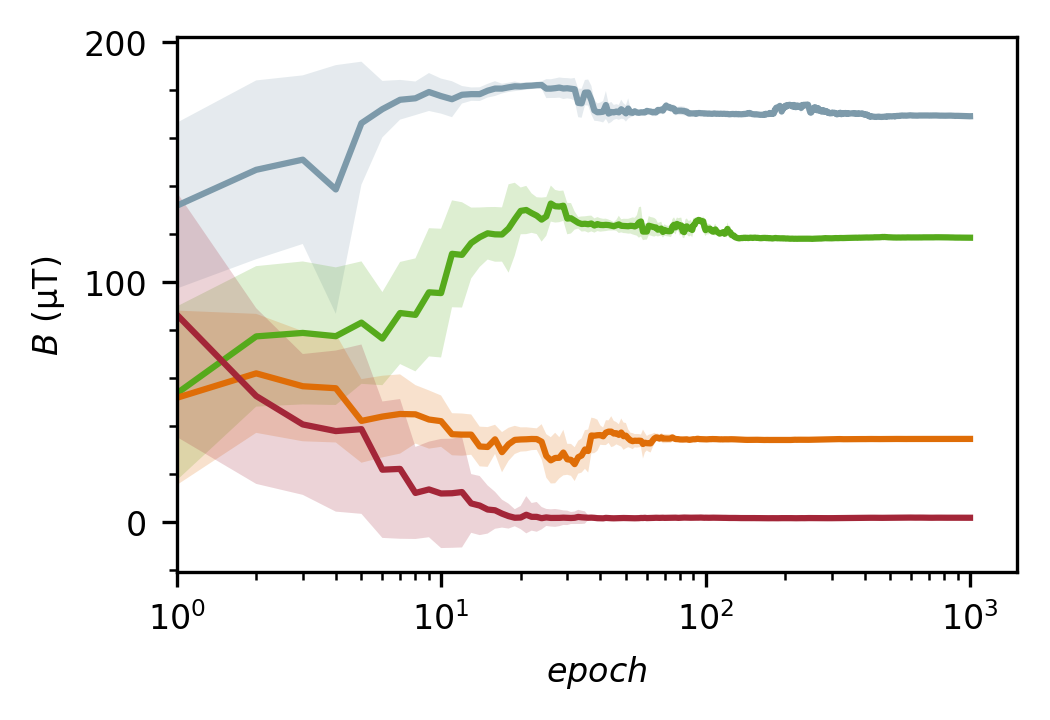

In [521]:

try:
    #plt.figure()
    plot_b_vs_epoch(mes_list)
        
    plt_settings.savefig('b_vs_epoch.png', frame_top_inch=0.15, frame_right_inch=0.15,
                         frame_left_inch=0.55, frame_bottom_inch=0.4)
except:
    logger.exception("")

plt.show()

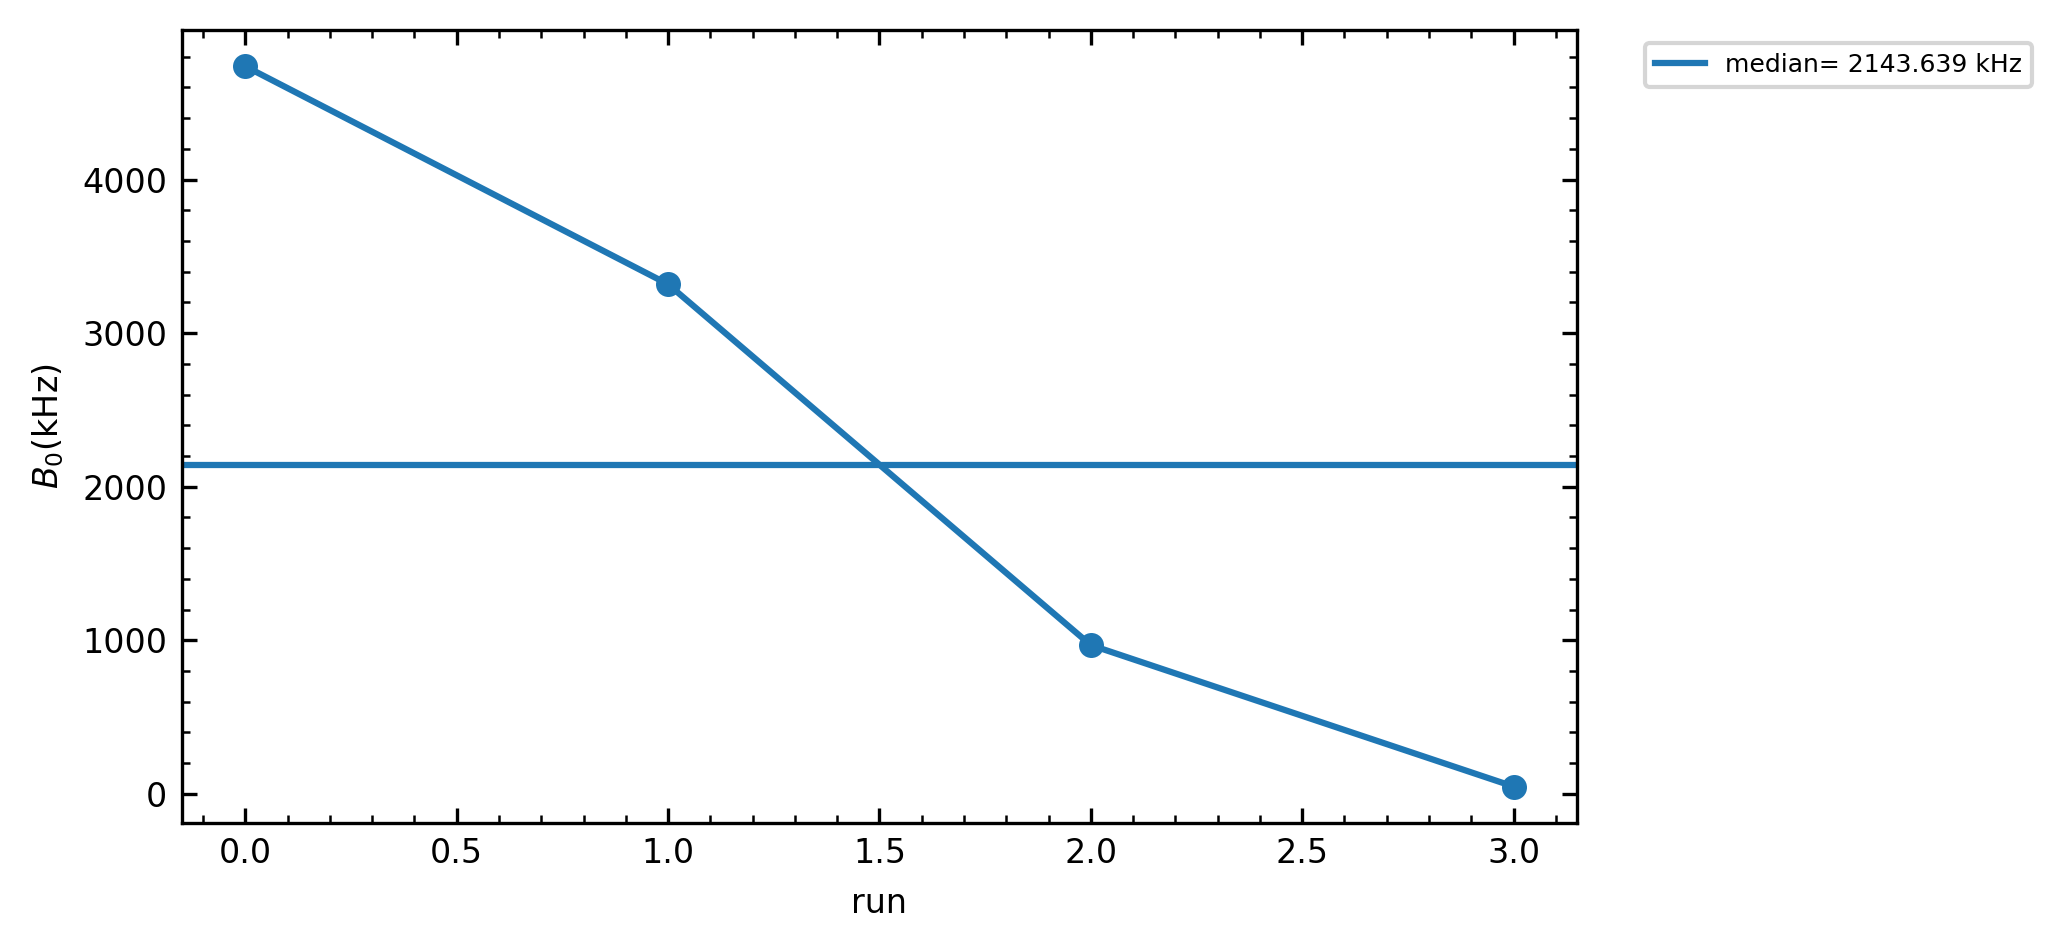

In [108]:
try:
    plot_b_vs_runs(mes_list)
except:
    logger.exception("")
    
plt.show()